# Pretraining Strategies

## 1. Same-Sector (Healthcare) Pretraining

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Seed setting
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(42)

In [2]:
# Feature Engineering
def engineer_features(df):
    df['returns'] = df['Close'].pct_change() * 100
    df['price_lag1'] = df['Close'].shift(1)
    df['price_lag2'] = df['Close'].shift(2)
    df['return_lag1'] = df['returns'].shift(1)
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_20'] = df['Close'].ewm(span=20).mean()
    df['norm_price'] = (df['Close'] - df['SMA_20']) / df['SMA_20'] * 100
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    ema_12 = df['Close'].ewm(span=12).mean()
    ema_26 = df['Close'].ewm(span=26).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    df['volatility_5'] = df['returns'].rolling(window=5).std()
    df['volatility_20'] = df['returns'].rolling(window=20).std()
    df['vol_ratio'] = df['volatility_5'] / df['volatility_20'].replace(0, np.nan)
    df.dropna(inplace=True)
    return df

# Sequence builder
def create_sequences(data, feature_cols, target_col='Close', N=30):
    X, y = [], []
    features = data[feature_cols].values
    target = data[target_col].values
    for i in range(len(data) - N):
        X.append(features[i:i+N])
        y.append(target[i+N])  # scalar value
    return np.array(X), np.array(y)  # ✅ y shape: (samples,)

# GRU model
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [3]:
# Load data
df = pd.read_csv("combined_stock_data.csv", parse_dates=['Date'])
stocks = {'RMD': None, 'COH': None, 'SHL': None, 'RHC': None, 'CSL': None}
feature_cols = ['Open', 'High', 'Low', 'Volume', 'returns', 'price_lag1', 'price_lag2',
                'return_lag1', 'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'RSI_14',
                'MACD', 'MACD_signal', 'volatility_5', 'volatility_20', 'vol_ratio']

for name in stocks.keys():
    temp_df = df[df['Name'] == name].copy().sort_values('Date')
    stocks[name] = engineer_features(temp_df)


In [4]:
# 2. Reset and load meta-pretrain sets
X_meta_list, y_meta_list = [], []

for name in ['RMD', 'COH', 'SHL', 'RHC']:
    seq_df = stocks[name][feature_cols + ['Close']]
    X, y = create_sequences(seq_df, feature_cols, 'Close')
    X_meta_list.append(X)
    y_meta_list.append(y)  # ✅ flatten y arrays before concatenating. Ensure y_meta_list has 1D arrays

# 3. Combine
X_meta = np.concatenate(X_meta_list, axis=0)  
y_meta = np.concatenate(y_meta_list, axis=0)

# 4. Sanity check
print("✅ Final shapes:")
print("X_meta:", X_meta.shape)  # e.g. (2432, 30, 20)
print("y_meta:", y_meta.shape)  # e.g. (2432, 1)
assert X_meta.shape[0] == y_meta.shape[0], "Mismatch in sample count!"

# Scale features
X_meta_reshaped = X_meta.reshape(-1, X_meta.shape[-1])
x_scaler = MinMaxScaler().fit(X_meta_reshaped)
X_meta_scaled = x_scaler.transform(X_meta_reshaped).reshape(X_meta.shape)

# Scale target
y_scaler = MinMaxScaler().fit(y_meta.reshape(-1, 1))  # ✅ fit on 2D
y_meta_scaled = y_scaler.transform(y_meta.reshape(-1, 1))

✅ Final shapes:
X_meta: (4864, 30, 18)
y_meta: (4864,)


In [5]:
# Pretrain
model = create_gru_model((X_meta_scaled.shape[1], X_meta_scaled.shape[2]))
model.fit(X_meta_scaled, y_meta_scaled, epochs=30, batch_size=32, verbose=1)

# -----------------------
# Fine-tuning on CSL
# -----------------------
seq_csl = stocks['CSL'][feature_cols + ['Close']]
X_csl, y_csl = create_sequences(seq_csl, feature_cols, 'Close')

# New scalers for CSL
x_scaler_csl = StandardScaler().fit(X_csl.reshape(-1, X_csl.shape[-1]))
X_csl_scaled = x_scaler_csl.transform(X_csl.reshape(-1, X_csl.shape[-1])).reshape(X_csl.shape)

y_scaler_csl = MinMaxScaler().fit(y_csl.reshape(-1, 1))
y_csl_scaled = y_scaler_csl.transform(y_csl.reshape(-1, 1))

split = int(len(X_csl_scaled) * 0.7)
X_csl_train, X_csl_val = X_csl_scaled[:split], X_csl_scaled[split:]
y_csl_train, y_csl_val = y_csl_scaled[:split], y_csl_scaled[split:]

finetune_model = create_gru_model((X_csl.shape[1], X_csl.shape[2]))
finetune_model.set_weights(model.get_weights())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
finetune_model.fit(X_csl_train, y_csl_train, validation_data=(X_csl_val, y_csl_val),
                   epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)

# Predict and evaluate
y_pred = finetune_model.predict(X_csl_val)
y_pred_inv = y_scaler_csl.inverse_transform(y_pred)
y_val_inv = y_scaler_csl.inverse_transform(y_csl_val)

same_rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
same_mae = mean_absolute_error(y_val_inv, y_pred_inv)
same_r2 = r2_score(y_val_inv, y_pred_inv)

print("📊 Fine-tuned CSL Model Performance (Same Sector Pretrain):")
print(f"RMSE: {same_rmse:.4f}, MAE: {same_mae:.4f}, R²: {same_r2:.4f}")

Epoch 1/30


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0269 - mae: 0.1075
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - mae: 0.0454
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - mae: 0.0364
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - mae: 0.0300
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - mae: 0.0285
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0.0263
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0.0257
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - mae: 0.0247
Epoch 9/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0241
Epoch 10/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0238
Epoch 11/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - mae: 0.0226
Epoch 12/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0215
Epoch 13/30
152/152 ━━━━━━━━━━━━━━━━

C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1025 - mae: 0.2464 - val_loss: 0.0242 - val_mae: 0.1290
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0233 - mae: 0.1148 - val_loss: 0.0174 - val_mae: 0.1084
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0121 - mae: 0.0860 - val_loss: 0.0166 - val_mae: 0.1058
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0113 - mae: 0.0822 - val_loss: 0.0168 - val_mae: 0.1029
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - mae: 0.0717 - val_loss: 0.0166 - val_mae: 0.1056
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0073 - mae: 0.0663 - val_loss: 0.0126 - val_mae: 0.0914
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - mae: 0.0651 - val_loss: 0.0118 - val_mae: 0.0904
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - mae: 0.0578 - val_loss: 0.0138 - val_mae: 0.0932
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - mae: 0.

## 2. Financial Sector Pretraining

In [6]:
financial_stocks = ['CBA', 'NAB', 'ANZ', 'WBC']

# Add Financial stocks into stocks dictionary
stocks = {name: None for name in financial_stocks + ['CSL']}  


# 1. Load and feature engineer
for name in stocks.keys():
    temp_df = df[df['Name'] == name].copy().sort_values('Date')
    stocks[name] = engineer_features(temp_df)

# 2. Create meta-pretrain sets using financial stocks
X_meta_list, y_meta_list = [], []

for name in financial_stocks:
    seq_df = stocks[name][feature_cols + ['Close']]
    X, y = create_sequences(seq_df, feature_cols, 'Close')
    X_meta_list.append(X)
    y_meta_list.append(y)

# 3. Combine
X_meta = np.concatenate(X_meta_list, axis=0)  
y_meta = np.concatenate(y_meta_list, axis=0)

# 4. Sanity check
print("✅ Final shapes:")
print("X_meta:", X_meta.shape)
print("y_meta:", y_meta.shape)
assert X_meta.shape[0] == y_meta.shape[0], "Mismatch in sample count!"

✅ Final shapes:
X_meta: (4864, 30, 18)
y_meta: (4864,)


In [7]:
# Scale features
X_meta_reshaped = X_meta.reshape(-1, X_meta.shape[-1])
x_scaler = MinMaxScaler().fit(X_meta_reshaped)
X_meta_scaled = x_scaler.transform(X_meta_reshaped).reshape(X_meta.shape)

# Scale target
y_scaler = MinMaxScaler().fit(y_meta.reshape(-1, 1))  # ✅ fit on 2D
y_meta_scaled = y_scaler.transform(y_meta.reshape(-1, 1))

# Pretrain on Financial Stocks
pretrained_fin_model = create_gru_model((X_meta_scaled.shape[1], X_meta_scaled.shape[2]))
pretrained_fin_model.fit(X_meta_scaled, y_meta_scaled, epochs=30, batch_size=32, verbose=1)

# -----------------------
# Fine-tuning on CSL
# -----------------------
seq_csl = stocks['CSL'][feature_cols + ['Close']]
X_csl, y_csl = create_sequences(seq_csl, feature_cols, 'Close')

# New scalers for CSL
x_scaler_csl = StandardScaler().fit(X_csl.reshape(-1, X_csl.shape[-1]))
X_csl_scaled = x_scaler_csl.transform(X_csl.reshape(-1, X_csl.shape[-1])).reshape(X_csl.shape)

y_scaler_csl = MinMaxScaler().fit(y_csl.reshape(-1, 1))
y_csl_scaled = y_scaler_csl.transform(y_csl.reshape(-1, 1))

split = int(len(X_csl_scaled) * 0.7)
X_csl_train, X_csl_val = X_csl_scaled[:split], X_csl_scaled[split:]
y_csl_train, y_csl_val = y_csl_scaled[:split], y_csl_scaled[split:]

# ✅ Create and load pretrained weights after data is ready
finetuned_csl_model = create_gru_model((X_csl.shape[1], X_csl.shape[2]))
finetuned_csl_model.set_weights(pretrained_fin_model.get_weights())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
finetuned_csl_model.fit(X_csl_train, y_csl_train,
                        validation_data=(X_csl_val, y_csl_val),
                        epochs=50, batch_size=16,
                        callbacks=[early_stop], verbose=1)

# Prediction and Evaluation
y_pred = finetuned_csl_model.predict(X_csl_val)
y_pred_inv = y_scaler_csl.inverse_transform(y_pred)
y_val_inv = y_scaler_csl.inverse_transform(y_csl_val)

fin_rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
fin_mae = mean_absolute_error(y_val_inv, y_pred_inv)
fin_r2 = r2_score(y_val_inv, y_pred_inv)

print("📊 Fine-tuned CSL Model Performance (Financial Sector Pretrain):")
print(f"RMSE: {fin_rmse:.4f}, MAE: {fin_mae:.4f}, R²: {fin_r2:.4f}")

Epoch 1/30


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0377 - mae: 0.1151
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - mae: 0.0392
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - mae: 0.0316
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - mae: 0.0270
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0241
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - mae: 0.0234
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0219
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0226
Epoch 9/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0213
Epoch 10/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0207
Epoch 11/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0393e-04 - mae: 0.0197
Epoch 12/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1851e-04 - mae: 0.0194
Epoch 13/30
152/152 ━━━━━━━━

C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2956 - mae: 0.3819 - val_loss: 0.0180 - val_mae: 0.1135
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0194 - mae: 0.1132 - val_loss: 0.0092 - val_mae: 0.0810
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0126 - mae: 0.0875 - val_loss: 0.0112 - val_mae: 0.0874
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0105 - mae: 0.0795 - val_loss: 0.0092 - val_mae: 0.0800
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0097 - mae: 0.0759 - val_loss: 0.0095 - val_mae: 0.0801
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
📊 Fine-tuned CSL Model Performance (Financial Sector Pretrain):
RMSE: 8.0273, MAE: 6.7751, R²: 0.8083


## 3. Mixed-Sector Pretraining (Healthecare + Financial)

In [8]:
# 1. Mixed-sector pretrain
meta_stocks = ['CBA', 'NAB', 'RMD', 'COH']

stocks = {name: None for name in meta_stocks + ['CSL']}

# Feature engineering
for name in stocks.keys():
    temp_df = df[df['Name'] == name].copy().sort_values('Date')
    stocks[name] = engineer_features(temp_df)
    
# 2. Create meta data
X_meta_list, y_meta_list = [], []

for name in meta_stocks:
    seq_df = stocks[name][feature_cols + ['Close']]
    X, y = create_sequences(seq_df, feature_cols, 'Close')
    X_meta_list.append(X)
    y_meta_list.append(y)

X_meta_mixed = np.concatenate(X_meta_list, axis=0)
y_meta_mixed = np.concatenate(y_meta_list, axis=0)

# 3. Scaling 
X_meta_reshaped = X_meta_mixed.reshape(-1, X_meta_mixed.shape[-1])
x_scaler_mixed = MinMaxScaler().fit(X_meta_reshaped)
X_meta_scaled = x_scaler_mixed.transform(X_meta_reshaped).reshape(X_meta_mixed.shape)

y_scaler_mixed = MinMaxScaler().fit(y_meta_mixed.reshape(-1, 1))
y_meta_scaled = y_scaler_mixed.transform(y_meta_mixed.reshape(-1, 1))

# 4. Pretrain
mixed_pretrained_model = create_gru_model((X_meta_scaled.shape[1], X_meta_scaled.shape[2]))
mixed_pretrained_model.fit(X_meta_scaled, y_meta_scaled, epochs=30, batch_size=32, verbose=1)

# -----------------------
# 5. Fine-tuning on CSL
# -----------------------
seq_csl = stocks['CSL'][feature_cols + ['Close']]
X_csl, y_csl = create_sequences(seq_csl, feature_cols, 'Close')

x_scaler_csl = StandardScaler().fit(X_csl.reshape(-1, X_csl.shape[-1]))
X_csl_scaled = x_scaler_csl.transform(X_csl.reshape(-1, X_csl.shape[-1])).reshape(X_csl.shape)

y_scaler_csl = MinMaxScaler().fit(y_csl.reshape(-1, 1))
y_csl_scaled = y_scaler_csl.transform(y_csl.reshape(-1, 1))

# 6. Train/Val split
split = int(len(X_csl_scaled) * 0.7)
X_csl_train, X_csl_val = X_csl_scaled[:split], X_csl_scaled[split:]
y_csl_train, y_csl_val = y_csl_scaled[:split], y_csl_scaled[split:]

# 7. Fine-tune on CSL
finetuned_mixed_model = create_gru_model((X_csl.shape[1], X_csl.shape[2]))
finetuned_mixed_model.set_weights(mixed_pretrained_model.get_weights())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
finetuned_mixed_model.fit(X_csl_train, y_csl_train,
                          validation_data=(X_csl_val, y_csl_val),
                          epochs=50, batch_size=16,
                          callbacks=[early_stop], verbose=1)

# 8. Prediction and Evaluation
y_pred_mixed = finetuned_mixed_model.predict(X_csl_val)
y_pred_inv_mixed = y_scaler_csl.inverse_transform(y_pred_mixed)
y_val_inv_mixed = y_scaler_csl.inverse_transform(y_csl_val)

rmse_mixed = np.sqrt(mean_squared_error(y_val_inv_mixed, y_pred_inv_mixed))
mae_mixed = mean_absolute_error(y_val_inv_mixed, y_pred_inv_mixed)
r2_mixed = r2_score(y_val_inv_mixed, y_pred_inv_mixed)

print("📊 Fine-tuned CSL Model Performance (Mixed-Sector Pretrain):")
print(f"RMSE: {rmse_mixed:.4f}, MAE: {mae_mixed:.4f}, R²: {r2_mixed:.4f}")


Epoch 1/30


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0345 - mae: 0.1189
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - mae: 0.0453
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - mae: 0.0358
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - mae: 0.0330
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - mae: 0.0298
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - mae: 0.0302
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - mae: 0.0283
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - mae: 0.0277
Epoch 9/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - mae: 0.0290
Epoch 10/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0260
Epoch 11/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - mae: 0.0243
Epoch 12/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - mae: 0.0242
Epoch 13/30
152/152 ━━━━━━━━━━━━━━━

C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1885 - mae: 0.3147 - val_loss: 0.0211 - val_mae: 0.1160
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0190 - mae: 0.1094 - val_loss: 0.0110 - val_mae: 0.0799
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0143 - mae: 0.0900 - val_loss: 0.0078 - val_mae: 0.0710
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117 - mae: 0.0830 - val_loss: 0.0067 - val_mae: 0.0668
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - mae: 0.0746 - val_loss: 0.0062 - val_mae: 0.0631
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0070 - mae: 0.0653 - val_loss: 0.0057 - val_mae: 0.0610
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - mae: 0.0584 - val_loss: 0.0066 - val_mae: 0.0664
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067 - mae: 0.0612 - val_loss: 0.0043 - val_mae: 0.0531
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0063 - mae: 0.

## 4. Clustering-based Pretraining

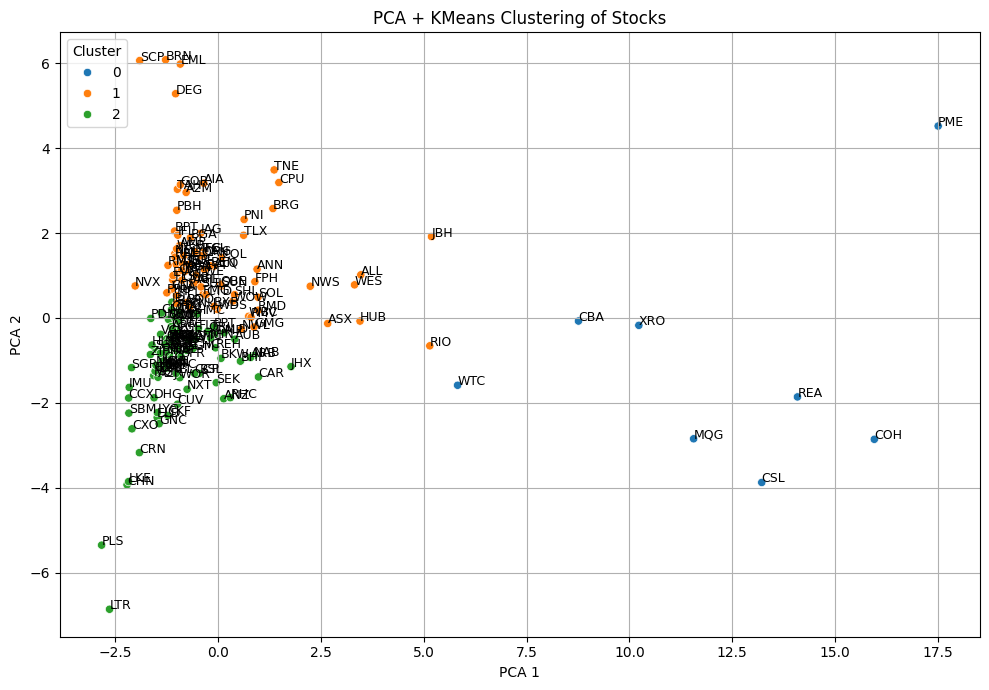

✅ Stocks clustered with CSL:
['CBA', 'CSL', 'MQG', 'COH', 'REA', 'XRO', 'WTC', 'PME']


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract average 30-day feature vectors
stock_feature_vectors = {}
for name in df['Name'].unique():
    temp = df[df['Name'] == name].copy()
    temp = engineer_features(temp)
    if all(col in temp.columns for col in feature_cols):
        recent_avg_vector = temp[feature_cols].tail(30).mean().values
        if not np.isnan(recent_avg_vector).any():
            stock_feature_vectors[name] = recent_avg_vector

# Step 2: PCA + Clustering
names = list(stock_feature_vectors.keys())
vectors = np.array([stock_feature_vectors[name] for name in names])
scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors_scaled)

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(pca_result)

# Step 3: Visualize
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='tab10')
for i, name in enumerate(names):
    plt.text(pca_result[i, 0], pca_result[i, 1], name, fontsize=9)
plt.title('PCA + KMeans Clustering of Stocks')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Find stocks in CSL's cluster
csl_index = names.index('CSL')
csl_cluster = clusters[csl_index]
similar_stocks = [names[i] for i, label in enumerate(clusters) if label == csl_cluster]

print("✅ Stocks clustered with CSL:")
print(similar_stocks)

In [10]:
stocks = {name: engineer_features(df[df['Name'] == name].copy().sort_values('Date')) for name in similar_stocks}

# Set columns
feature_cols = ['Open', 'High', 'Low', 'Volume', 'returns', 'price_lag1', 'price_lag2',
                'return_lag1', 'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'RSI_14',
                'MACD', 'MACD_signal', 'volatility_5', 'volatility_20', 'vol_ratio']

# Pretrain on all except CSL
pretrain_stocks = [s for s in similar_stocks if s != 'CSL']
X_meta_list, y_meta_list = [], []
for name in pretrain_stocks:
    seq_df = stocks[name][feature_cols + ['Close']]
    X, y = create_sequences(seq_df, feature_cols)
    X_meta_list.append(X)
    y_meta_list.append(y)

X_meta = np.concatenate(X_meta_list, axis=0)
y_meta = np.concatenate(y_meta_list, axis=0)

# Scale
x_scaler = MinMaxScaler().fit(X_meta.reshape(-1, X_meta.shape[-1]))
X_meta_scaled = x_scaler.transform(X_meta.reshape(-1, X_meta.shape[-1])).reshape(X_meta.shape)

y_scaler = MinMaxScaler().fit(y_meta.reshape(-1, 1))
y_meta_scaled = y_scaler.transform(y_meta.reshape(-1, 1))

# Pretrain model
pretrained_cluster_model = create_gru_model((X_meta.shape[1], X_meta.shape[2]))
pretrained_cluster_model.fit(X_meta_scaled, y_meta_scaled, epochs=30, batch_size=32, verbose=1)

# Fine-tune on CSL
X_csl, y_csl = create_sequences(stocks['CSL'][feature_cols + ['Close']], feature_cols)
x_scaler_csl = StandardScaler().fit(X_csl.reshape(-1, X_csl.shape[-1]))
X_csl_scaled = x_scaler_csl.transform(X_csl.reshape(-1, X_csl.shape[-1])).reshape(X_csl.shape)
y_scaler_csl = MinMaxScaler().fit(y_csl.reshape(-1, 1))
y_csl_scaled = y_scaler_csl.transform(y_csl.reshape(-1, 1))

split = int(len(X_csl_scaled) * 0.7)
X_csl_train, X_csl_val = X_csl_scaled[:split], X_csl_scaled[split:]
y_csl_train, y_csl_val = y_csl_scaled[:split], y_csl_scaled[split:]

finetuned_csl_model = create_gru_model((X_csl.shape[1], X_csl.shape[2]))
finetuned_csl_model.set_weights(pretrained_cluster_model.get_weights())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
finetuned_csl_model.fit(X_csl_train, y_csl_train,
                        validation_data=(X_csl_val, y_csl_val),
                        epochs=50, batch_size=16,
                        callbacks=[early_stop], verbose=1)

# Evaluation
y_pred = finetuned_csl_model.predict(X_csl_val)
y_pred_inv = y_scaler_csl.inverse_transform(y_pred)
y_val_inv = y_scaler_csl.inverse_transform(y_csl_val)

rmse_cluster = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
mae_cluster = mean_absolute_error(y_val_inv, y_pred_inv)
r2_cluster = r2_score(y_val_inv, y_pred_inv)

print("📊 Fine-tuned CSL Model Performance (Cluster-Based Pretrain):")
print(f"RMSE: {rmse_cluster:.4f}, MAE: {mae_cluster:.4f}, R²: {r2_cluster:.4f}")

Epoch 1/30


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0105 - mae: 0.0724
Epoch 2/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0020 - mae: 0.0330
Epoch 3/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - mae: 0.0272
Epoch 4/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - mae: 0.0243
Epoch 5/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - mae: 0.0238
Epoch 6/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.8357e-04 - mae: 0.0229
Epoch 7/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.9503e-04 - mae: 0.0219
Epoch 8/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5556e-04 - mae: 0.0198
Epoch 9/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9167e-04 - mae: 0.0191
Epoch 10/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6057e-04 - mae: 0.0184
Epoch 11/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5740e-04 - mae: 0.0187
Epoch 12/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.2124e-04 - mae: 0.0180
Epoch 13

C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1103 - mae: 0.2585 - val_loss: 0.0440 - val_mae: 0.1776
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0186 - mae: 0.1064 - val_loss: 0.0422 - val_mae: 0.1605
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0124 - mae: 0.0853 - val_loss: 0.0368 - val_mae: 0.1454
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0092 - mae: 0.0739 - val_loss: 0.0326 - val_mae: 0.1324
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - mae: 0.0695 - val_loss: 0.0258 - val_mae: 0.1158
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - mae: 0.0617 - val_loss: 0.0251 - val_mae: 0.1100
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - mae: 0.0580 - val_loss: 0.0202 - val_mae: 0.0987
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - mae: 0.0569 - val_loss: 0.0177 - val_mae: 0.0931
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - mae: 0.

# Sector-Aware Contrastive Learning (Meta-Representation Learning)
## 5. Sector-Aware Contrastive Learning

### 5-1. Manual Mapping from GICS Industry Group to Broad Sectors

In [11]:
gics_to_sector = {
    # Healthcare
    "Health Care Equipment & Services": "Health Care",
    "Pharmaceuticals, Biotechnology & Life Sciences": "Health Care",

    # Financials
    "Banks": "Financials",
    "Insurance": "Financials",
    "Financial Services": "Financials",

    # Technology
    "Software & Services": "Technology",
    "Technology Hardware & Equipment": "Technology",
    "Semiconductors & Semiconductor Equipment": "Technology",

    # Consumer
    "Consumer Discretionary Distribution & Retail": "Consumer",
    "Consumer Durables & Apparel": "Consumer",
    "Consumer Services": "Consumer",
    "Consumer Staples Distribution & Retail": "Consumer",

    # Real Estate
    "Equity Real Estate Investment Trusts (REITs)": "Real Estate",
    "Real Estate Management & Development": "Real Estate",

    # Energy, Materials, etc.
    "Energy": "Energy",
    "Materials": "Materials",
    "Utilities": "Utilities",
    "Telecommunication Services": "Telecom",
    "Transportation": "Transportation",
    "Media & Entertainment": "Media",
    "Food, Beverage & Tobacco": "Consumer",
    "Household & Personal Products": "Consumer",
    "Commercial & Professional Services": "Industrials",
    "Capital Goods": "Industrials",
    "Automobiles & Components": "Industrials",

    # Other
    "Class Pend": "Other",
    "Not Applic": "Other",
}

In [12]:
# Load ASX company info with sector/industry
company_info = pd.read_csv("ASXListedCompanies.csv", skiprows=1)
company_info.columns = ["Company name", "ASX code", "Industry group"]

# Clean up company name column (remove whitespace)
company_info["Company name"] = company_info["Company name"].str.strip()
company_info["ASX code"] = company_info["ASX code"].str.strip()

# Apply mapping
company_info["Sector"] = company_info["Industry group"].map(gics_to_sector)

# Merge sector information into stock data
df["Name"] = df["Name"].str.strip()
merged_df = df.merge(company_info[["ASX code", "Sector"]],
                           left_on="Name", right_on="ASX code", how="left")

# Optional: check for missing sector info
missing = merged_df[merged_df["Sector"].isnull()]["Name"].unique()
print("⚠️ Missing sector info for:", missing)
# Remove rows with missing sector info
merged_df = merged_df[~merged_df["Sector"].isnull()].copy()


print(merged_df["Sector"].value_counts(dropna=False))
print(merged_df[merged_df['Name'].isin(['CSL', 'COH', 'RMD', 'CBA', 'NAB'])][['Name', 'Sector']].drop_duplicates())

⚠️ Missing sector info for: ['IPL']
Sector
Materials         42837
Consumer          37029
Financials        35448
Real Estate       28383
Health Care       16458
Industrials       13926
Energy            10128
Technology        10128
Transportation     8862
Media              8862
Telecom            3798
Utilities          3798
Name: count, dtype: int64
      Name       Sector
0      CBA   Financials
2532   CSL  Health Care
7596   NAB   Financials
29118  COH  Health Care
86088  RMD  Health Care


### 5-2. Positive/Negative Pair Construction Based on Sector Labels

In [13]:
from itertools import combinations
from collections import defaultdict

# Step 1: Group by Sector
sector_groups = merged_df.groupby('Sector')['Name'].unique().to_dict()

# Step 2: Create positive pairs (same sector)
positive_pairs = []
for names in sector_groups.values():
    pairs = list(combinations(names, 2))
    positive_pairs.extend(pairs)

# Step 3: Create negative pairs (different sectors)
all_names = merged_df['Name'].unique()
negative_pairs = []
seen = set()
for i, name1 in enumerate(all_names):
    sector1 = merged_df[merged_df['Name'] == name1]['Sector'].iloc[0]
    for j in range(i+1, len(all_names)):
        name2 = all_names[j]
        sector2 = merged_df[merged_df['Name'] == name2]['Sector'].iloc[0]
        if sector1 != sector2:
            key = tuple(sorted([name1, name2]))
            if key not in seen:
                negative_pairs.append((name1, name2))
                seen.add(key)

print(f"✅ Positive pairs: {len(positive_pairs)}")
print(f"✅ Negative pairs: {len(negative_pairs)}")

✅ Positive pairs: 1894
✅ Negative pairs: 13506


### 5-3. Extract latest 30-day Average Feature Vector per Stock

In [14]:
def get_avg_vector(stock_name):
    df_stock = merged_df[merged_df["Name"] == stock_name].copy()
    df_stock = engineer_features(df_stock)
    if len(df_stock) < 30:
        return None
    recent_vector = df_stock[feature_cols].tail(30).mean().values
    if np.isnan(recent_vector).any():
        return None
    return recent_vector

# Build embedding dict
embedding_dict = {}
for name in merged_df['Name'].unique():
    vec = get_avg_vector(name)
    if vec is not None:
        embedding_dict[name] = vec

# Filter pairs for which we have valid vectors
positive_pairs = [pair for pair in positive_pairs if pair[0] in embedding_dict and pair[1] in embedding_dict]
negative_pairs = [pair for pair in negative_pairs if pair[0] in embedding_dict and pair[1] in embedding_dict]

print(f"Filtered positive pairs: {len(positive_pairs)}")
print(f"Filtered negative pairs: {len(negative_pairs)}")

Filtered positive pairs: 1864
Filtered negative pairs: 13361


### 5-4. Creating Triplet (Anchor, Positive, Negative) 

In [15]:
import random

def create_contrastive_triplets(X, y, max_triplets=2000):
    """
    Generate (anchor, positive, negative) triplets for contrastive learning.
    - X: np.array of shape (N, T, D) – sequence data
    - y: np.array of shape (N,) – label (e.g., sector)
    """
    class_to_indices = {}
    for i, label in enumerate(y):
        class_to_indices.setdefault(label, []).append(i)

    triplets = []
    all_indices = list(range(len(X)))
    num_generated = 0
    while num_generated < max_triplets:
        # Select anchor
        anchor_idx = random.choice(all_indices)
        anchor_label = y[anchor_idx]

        # Positive (same class)
        pos_candidates = class_to_indices[anchor_label]
        pos_candidates = [i for i in pos_candidates if i != anchor_idx]
        if not pos_candidates:
            continue
        pos_idx = random.choice(pos_candidates)

        # Negative (different class)
        neg_labels = [label for label in class_to_indices if label != anchor_label]
        if not neg_labels:
            continue
        neg_label = random.choice(neg_labels)
        neg_idx = random.choice(class_to_indices[neg_label])

        # Add triplet
        triplets.append((X[anchor_idx], X[pos_idx], X[neg_idx]))
        num_generated += 1

    return np.array(triplets)

In [16]:
# Step 1: Prepare stocks dict with engineered features
stocks = {}
for name in merged_df['Name'].unique():
    temp_df = merged_df[merged_df["Name"] == name].copy().sort_values("Date")
    stocks[name] = engineer_features(temp_df)

# Step 2: Encode sector labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder first
label_encoder.fit(merged_df['Sector'])

# Add sector labels directly to merged_df
merged_df['SectorLabel'] = label_encoder.transform(merged_df['Sector'])

# Create mapping from name to sector label
name_to_label = merged_df.groupby('Name')['SectorLabel'].first().to_dict()

# Step 3: Build X_all and y_all
X_all, y_all = [], []
for name in stocks:
    if name == 'CSL': continue
    data = stocks[name]
    X_seq, _ = create_sequences(data, feature_cols)
    
    # ✅ Skip invalid shapes
    if X_seq.ndim != 3:
        print(f"⚠️ Skipping {name} due to invalid shape: {X_seq.shape}")
        continue

    if name in name_to_label:
        label = name_to_label[name]
        X_all.append(X_seq)
        y_all.extend([label] * len(X_seq))

X_all = np.concatenate(X_all)
y_all = np.array(y_all)

# Step 4: Create triplets
triplets = create_contrastive_triplets(X_all, y_all, max_triplets=2000)
print(f"✅ Total triplets generated: {len(triplets)}")

⚠️ Skipping SCP due to invalid shape: (0,)
✅ Total triplets generated: 2000


### 5-5. Triplet Network Architecture (Siamese-like with Shared GRU Encoder)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Shared encoder
def create_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.GRU(64, return_sequences=False)(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32)(x)  # Embedding space
    return Model(inputs, x, name="encoder")

# Triplet loss
def triplet_loss(margin=1.0):
    def _loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)
    return _loss

# Triplet model wrapper
def build_triplet_model(input_shape):
    encoder = create_encoder(input_shape)
    
    anchor_input = tf.keras.Input(shape=input_shape, name="anchor")
    positive_input = tf.keras.Input(shape=input_shape, name="positive")
    negative_input = tf.keras.Input(shape=input_shape, name="negative")

    encoded_anchor = encoder(anchor_input)
    encoded_positive = encoder(positive_input)
    encoded_negative = encoder(negative_input)

    # Use Lambda to stack outputs
    merged_output = layers.Lambda(lambda x: tf.stack(x, axis=1))(
        [encoded_anchor, encoded_positive, encoded_negative]
    )

    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
    model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))
    return model

In [18]:
# triplets.shape == (1864, 3, 30, features)
triplets = np.array(triplets)
X_anchor   = triplets[:, 0]  # shape: (1864, 30, features)
X_positive = triplets[:, 1]  # shape: (1864, 30, features)
X_negative = triplets[:, 2]  # shape: (1864, 30, features)

print(type(triplets))       
print(triplets.shape)         

# X_anchor, X_positive, X_negative (shape: [n, 30, features])
triplet_ds = tf.data.Dataset.from_tensor_slices((
    {
        "anchor": X_anchor,
        "positive": X_positive,
        "negative": X_negative,
    },
    np.zeros(len(X_anchor))  # dummy labels, not used
)).shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

triplet_model = build_triplet_model(input_shape=(X_anchor.shape[1], X_anchor.shape[2]))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

triplet_model.fit(
    triplet_ds,
    epochs=20,
    verbose=2,
    callbacks=[early_stop]  
)

<class 'numpy.ndarray'>
(2000, 3, 30, 18)

Epoch 1/20
63/63 - 8s - 124ms/step - loss: 1.0214
Epoch 2/20
63/63 - 1s - 20ms/step - loss: 1.0001
Epoch 3/20
63/63 - 1s - 23ms/step - loss: 0.9964
Epoch 4/20
63/63 - 1s - 21ms/step - loss: 0.9957
Epoch 5/20
63/63 - 1s - 18ms/step - loss: 0.9954
Epoch 6/20
63/63 - 1s - 23ms/step - loss: 0.9945
Epoch 7/20
63/63 - 2s - 25ms/step - loss: 0.9918
Epoch 8/20
63/63 - 2s - 25ms/step - loss: 0.9918
Epoch 9/20
63/63 - 1s - 21ms/step - loss: 0.9934
Epoch 10/20
63/63 - 1s - 24ms/step - loss: 0.9908
Epoch 11/20
63/63 - 1s - 22ms/step - loss: 0.9907
Epoch 12/20
63/63 - 1s - 19ms/step - loss: 0.9900
Epoch 13/20
63/63 - 1s - 21ms/step - loss: 0.9904
Epoch 14/20
63/63 - 1s - 22ms/step - loss: 0.9896
Epoch 15/20
63/63 - 1s - 20ms/step - loss: 0.9892
Epoch 16/20
63/63 - 1s - 19ms/step - loss: 0.9889
Epoch 17/20
63/63 - 1s - 21ms/step - loss: 0.9888
Epoch 18/20
63/63 - 2s - 27ms/step - loss: 0.9886
Epoch 19/20
63/63 - 1s - 23ms/step - loss: 0.9882
Epoch 20/20
63/

### 5-6. Pretrained GRU Encoder -> MLP Regressor for CSL

In [19]:
# Step 1: Extract Encoder
encoder = triplet_model.get_layer("encoder")

# Step 2: Preprocess and encode CSL data
# Create sequences for CSL
X_csl, y_csl = create_sequences(stocks["CSL"], feature_cols, target_col="Close")

# Feature normalization
x_scaler_csl = StandardScaler().fit(X_csl.reshape(-1, X_csl.shape[-1]))
X_csl_scaled = x_scaler_csl.transform(X_csl.reshape(-1, X_csl.shape[-1])).reshape(X_csl.shape)

# Target normalization
from sklearn.preprocessing import MinMaxScaler
y_scaler_csl = MinMaxScaler().fit(y_csl.reshape(-1, 1))
y_csl_scaled = y_scaler_csl.transform(y_csl.reshape(-1, 1))

# Encode sequences using encoder
X_csl_encoded = encoder.predict(X_csl_scaled)

# Step 3: Define and train regression model on encoded features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

regressor = Sequential([
    Dense(64, activation='relu', input_shape=(X_csl_encoded.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Split into training and validation sets
split = int(len(X_csl_encoded) * 0.7)
X_train, X_val = X_csl_encoded[:split], X_csl_encoded[split:]
y_train, y_val = y_csl_scaled[:split], y_csl_scaled[split:]

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

regressor.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)

# Step 4: Prediction and evaluation
y_pred = regressor.predict(X_val)
y_pred_inv = y_scaler_csl.inverse_transform(y_pred)
y_val_inv = y_scaler_csl.inverse_transform(y_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
encoder_rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
encoder_mae = mean_absolute_error(y_val_inv, y_pred_inv)
encoder_r2 = r2_score(y_val_inv, y_pred_inv)

print("📊 CSL Regression via Encoder Embedding:")
print(f"RMSE: {encoder_rmse:.4f}, MAE: {encoder_mae:.4f}, R²: {encoder_r2:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/50


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1029 - mae: 0.2627 - val_loss: 0.0356 - val_mae: 0.1586
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - mae: 0.1385 - val_loss: 0.0198 - val_mae: 0.1144
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - mae: 0.1008 - val_loss: 0.0130 - val_mae: 0.0948
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - mae: 0.0894 - val_loss: 0.0079 - val_mae: 0.0699
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - mae: 0.0802 - val_loss: 0.0066 - val_mae: 0.0641
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0686 - val_loss: 0.0050 - val_mae: 0.0548
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - mae: 0.0647 - val_loss: 0.0047 - val_mae: 0.0531
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0610 - val_loss: 0.0040 - val_mae: 0.0489
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0588 - va

### 5-7. Pretrained GRU Encoder -> CNN Regressor for CSL

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, Reshape

# Step 1: Reshape encoder output for CNN input
# X_csl_encoded shape: (samples, embedding_dim=32)
# CNN expects 3D input: (samples, time_steps, channels)
X_csl_encoded_cnn = X_csl_encoded.reshape(-1, X_csl_encoded.shape[1], 1)

# Step 2: Build CNN-based regressor
cnn_regressor = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_csl_encoded.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)  # Final output
])

cnn_regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train/test split
X_train_cnn = X_csl_encoded_cnn[:split]
X_val_cnn = X_csl_encoded_cnn[split:]

# Step 4: Fit
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_regressor.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),
                  epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)

# Step 5: Evaluation
y_pred_cnn = cnn_regressor.predict(X_val_cnn)
y_pred_inv_cnn = y_scaler_csl.inverse_transform(y_pred_cnn)
y_val_inv = y_scaler_csl.inverse_transform(y_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_cnn = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv_cnn))
mae_cnn = mean_absolute_error(y_val_inv, y_pred_inv_cnn)
r2_cnn = r2_score(y_val_inv, y_pred_inv_cnn)

print("📊 CSL Prediction using CNN Regressor on GRU Embeddings:")
print(f"RMSE: {rmse_cnn:.4f}, MAE: {mae_cnn:.4f}, R²: {r2_cnn:.4f}")


Epoch 1/50


C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2603 - mae: 0.4617 - val_loss: 0.0444 - val_mae: 0.1750
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - mae: 0.1419 - val_loss: 0.0336 - val_mae: 0.1394
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - mae: 0.1242 - val_loss: 0.0292 - val_mae: 0.1290
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216 - mae: 0.1161 - val_loss: 0.0274 - val_mae: 0.1271
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - mae: 0.1131 - val_loss: 0.0261 - val_mae: 0.1231
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - mae: 0.1096 - val_loss: 0.0250 - val_mae: 0.1188
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196 - mae: 0.1080 - val_loss: 0.0239 - val_mae: 0.1147
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - mae: 0.1061 - val_loss: 0.0226 - val_mae: 0.1095
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - mae: 0.1035 - v

# Final Comparison
## Model Performance Comparison Across All Strategies

In [21]:
results = pd.DataFrame([
    {
        "Model": "Original Fine-tuned CSL only",
        "RMSE": 3.6027,
        "MAE": 2.8294,
        "R²": 0.8830
    },
    {
        "Model": "Same Sector Pretrain",
        "RMSE": same_rmse,
        "MAE": same_mae,
        "R²": same_r2
    },
    {
        "Model": "Financial Sector Pretrain",
        "RMSE": fin_rmse,
        "MAE": fin_mae,
        "R²": fin_r2
    },
    {
        "Model": "Mixed Sector Pretrain",
        "RMSE": rmse_mixed,
        "MAE": mae_mixed,
        "R²": r2_mixed
    },
    {
        "Model": "Clustering based Pretrain",
        "RMSE": rmse_cluster,
        "MAE": mae_cluster,
        "R²": r2_cluster
    },
    {
        "Model": "GRU Encoder-CNN Regressor",
        "RMSE": rmse_cnn,
        "MAE": mae_cnn,
        "R²": r2_cnn
    }
])

from IPython.display import display
results[['RMSE', 'MAE', 'R²']] = results[['RMSE', 'MAE', 'R²']].applymap(lambda x: round(x, 2))
results_sorted = results.sort_values(by="R²", ascending=False)
display(results_sorted)

C:\Users\jiyoo\AppData\Local\Temp\ipykernel_27976\2958334147.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[['RMSE', 'MAE', 'R²']] = results[['RMSE', 'MAE', 'R²']].applymap(lambda x: round(x, 2))


,Model,RMSE,MAE,R²
3,Mixed Sector Pretrain,5.52,4.44,0.91
0,Original Fine-tuned CSL only,3.60,2.83,0.88
5,GRU Encoder-CNN Regressor,6.68,4.95,0.87
4,Clustering based Pretrain,7.60,5.48,0.83
1,Same Sector Pretrain,7.83,6.35,0.82
2,Financial Sector Pretrain,8.03,6.78,0.81


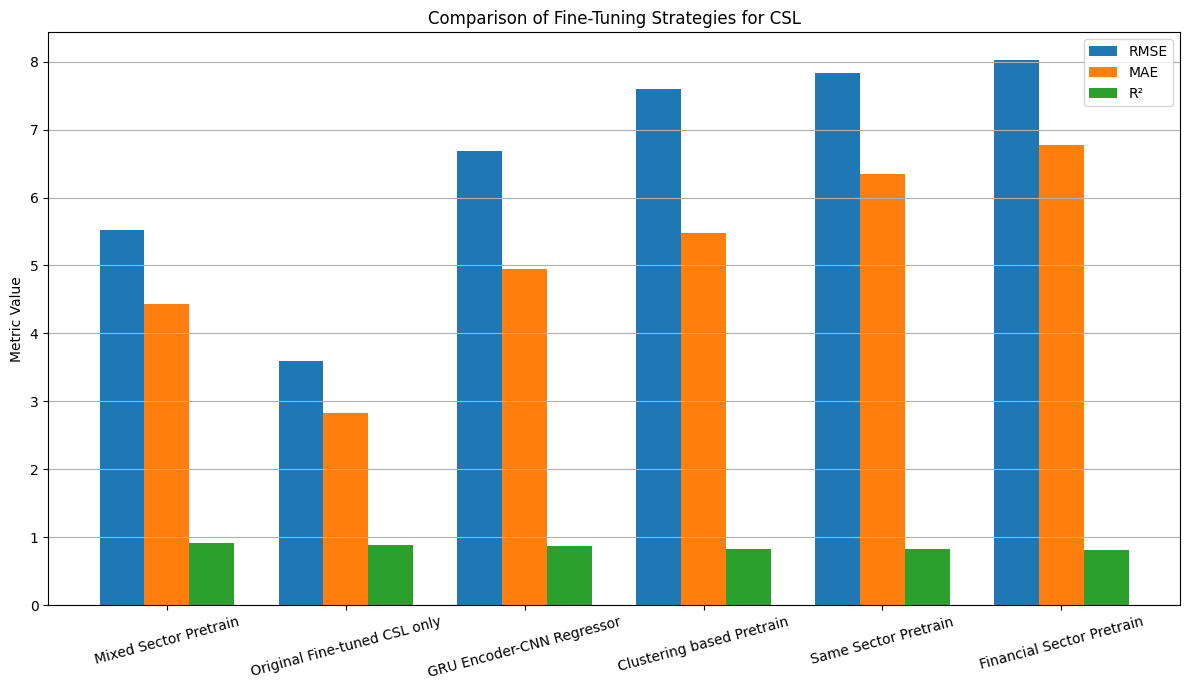

In [22]:
import matplotlib.pyplot as plt
import numpy as np

labels = results_sorted['Model']
rmse_vals = results_sorted['RMSE']
mae_vals = results_sorted['MAE']
r2_vals = results_sorted['R²']

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
bar1 = ax.bar(x - width, rmse_vals, width, label='RMSE')
bar2 = ax.bar(x, mae_vals, width, label='MAE')
bar3 = ax.bar(x + width, r2_vals, width, label='R²')

ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Fine-Tuning Strategies for CSL')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

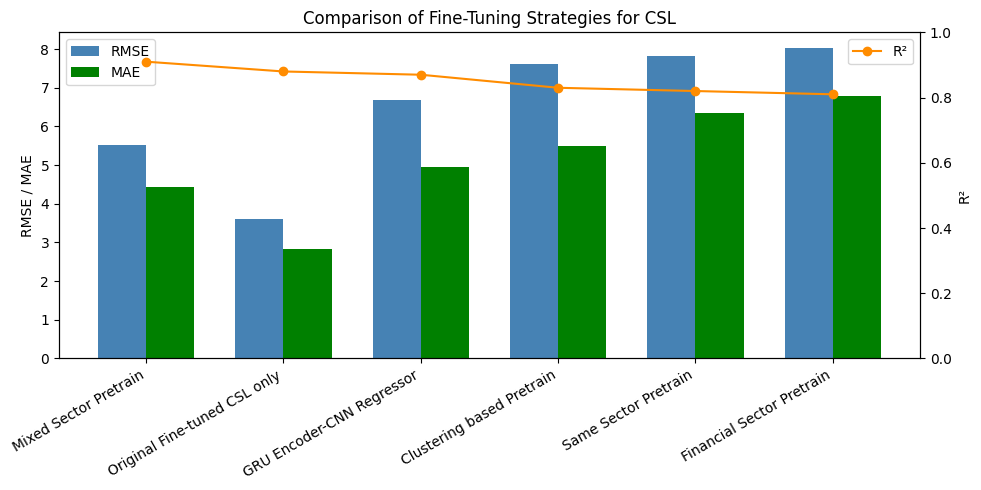

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar for RMSE and MAE
x = results_sorted["Model"]
x_index = np.arange(len(x))
width = 0.35

ax1.bar(x_index - width/2, results_sorted["RMSE"], width, label='RMSE', color='steelblue')
ax1.bar(x_index + width/2, results_sorted["MAE"], width, label='MAE', color='green')
ax1.set_ylabel("RMSE / MAE")
ax1.set_xticks(x_index)
ax1.set_xticklabels(x, rotation=30, ha='right')
ax1.legend(loc='upper left')

# Second axis for R²
ax2 = ax1.twinx()
ax2.plot(x_index, results_sorted["R²"], color='darkorange', marker='o', label="R²")
ax2.set_ylabel("R²")
ax2.set_ylim(0, 1)  # since R² ∈ [0,1]
ax2.legend(loc='upper right')

plt.title("Comparison of Fine-Tuning Strategies for CSL")
plt.tight_layout()
plt.show()

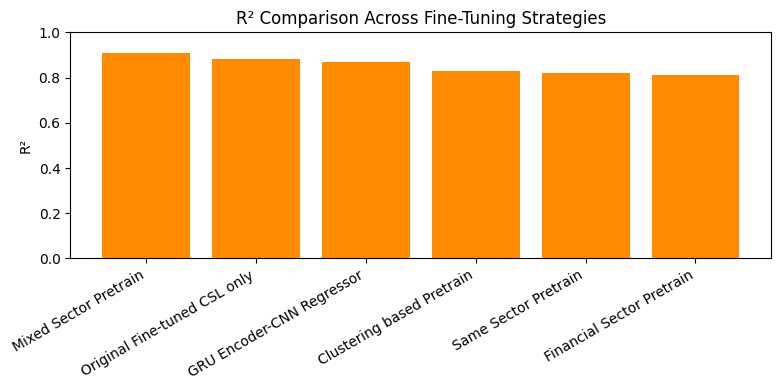

In [24]:
plt.figure(figsize=(8, 4))
plt.bar(results_sorted["Model"], results_sorted["R²"], color='darkorange')
plt.title("R² Comparison Across Fine-Tuning Strategies")
plt.ylabel("R²")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()